In [16]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
import re

# ==========================================
# 1. データベースの準備
# ==========================================
dbname = 'saishukadai.db'
conn = sqlite3.connect(dbname)
cur = conn.cursor()
cur.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT,
        station TEXT,
        price INTEGER,
        age INTEGER,
        floor_plan TEXT
    )
''')
conn.commit()

# ==========================================
# 2. スクレイピング設定
# ==========================================
# 【変更箇所】千葉県木更津市の賃貸・安い順のURL
# ta=12 (千葉県), sc=12206 (木更津市) を指定
base_url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=12&sc=12206&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&srch_navi=1"

def get_data():
    # 偽装用のヘッダー
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    # 1〜3ページ目を取得
    # ※木更津市の物件数が少ない場合、途中で break するようになっています
    for page in range(1, 4):
        print(f"--- Page {page} (木更津市) を取得中... ---")
        url = f"{base_url}&page={page}"
        
        try:
            res = requests.get(url, headers=headers)
            res.encoding = 'utf-8'
            
            if res.status_code != 200:
                print(f"アクセスエラー: {res.status_code}")
                continue

            soup = BeautifulSoup(res.text, 'html.parser')
            items = soup.find_all("div", class_="cassetteitem")

            if not items:
                print("物件情報が見つかりませんでした（これ以上ページがない可能性があります）")
                break

            data_list = []
            
            for item in items:
                try:
                    # 物件名
                    title_elem = item.find("div", class_="cassetteitem_content-title")
                    name = title_elem.text.strip() if title_elem else "不明"
                    
                    # 最寄駅
                    station_elem = item.find("div", class_="cassetteitem_detail-col1")
                    station = station_elem.text.strip() if station_elem else "不明"
                    
                    # 築年数
                    age_elem = item.find("li", class_="cassetteitem_detail-col3")
                    if age_elem:
                        age_text = age_elem.find_all("div")[0].text.strip()
                        if "新築" in age_text:
                            age = 0
                        else:
                            age_match = re.search(r'\d+', age_text)
                            age = int(age_match.group()) if age_match else 99
                    else:
                        age = 99

                    # 部屋情報のループ
                    tbody = item.find("table", class_="cassetteitem_other")
                    if tbody:
                        for tr in tbody.find("tbody").find_all("tr"):
                            try:
                                # 家賃
                                price_elem = tr.find_all("td")[3].find("li")
                                if price_elem:
                                    price_text = price_elem.text.strip()
                                    price = int(float(price_text.replace("万円", "")) * 10000)
                                else:
                                    continue

                                # 間取り
                                floor_plan_elem = tr.find_all("td")[2]
                                floor_plan = floor_plan_elem.text.strip() if floor_plan_elem else "不明"

                                data_list.append((name, station, price, age, floor_plan))
                            except Exception:
                                continue

                except Exception as e:
                    print(f"物件の解析エラー: {e}")
                    continue

            # DBへ保存
            if data_list:
                cur.executemany("INSERT INTO properties (name, station, price, age, floor_plan) VALUES (?, ?, ?, ?, ?)", data_list)
                conn.commit()
                print(f" -> {len(data_list)} 件保存しました")
            else:
                print(" -> 保存するデータがありませんでした")
            
            time.sleep(3)
            
        except Exception as e:
            print(f"ページ取得エラー: {e}")
            break

# 実行
get_data()
conn.close()
print(f"完了！ {dbname} に保存しました。")

--- Page 1 (木更津市) を取得中... ---
 -> 30 件保存しました
--- Page 2 (木更津市) を取得中... ---
 -> 30 件保存しました
--- Page 3 (木更津市) を取得中... ---
 -> 30 件保存しました
完了！ saishukadai.db に保存しました。


データ件数: 90件
   id        name station  price  age floor_plan
0   1  ブルジェオンフルール      不明  69000    2         1階
1   2   アンソレイエ　II      不明  63500    9         2階
2   3     ドルフ文京　Ａ      不明  70000    6         2階
3   4   メゾン　あい・あこ      不明  59000   13         3階
4   5       エタンセル      不明  52000    7         1階


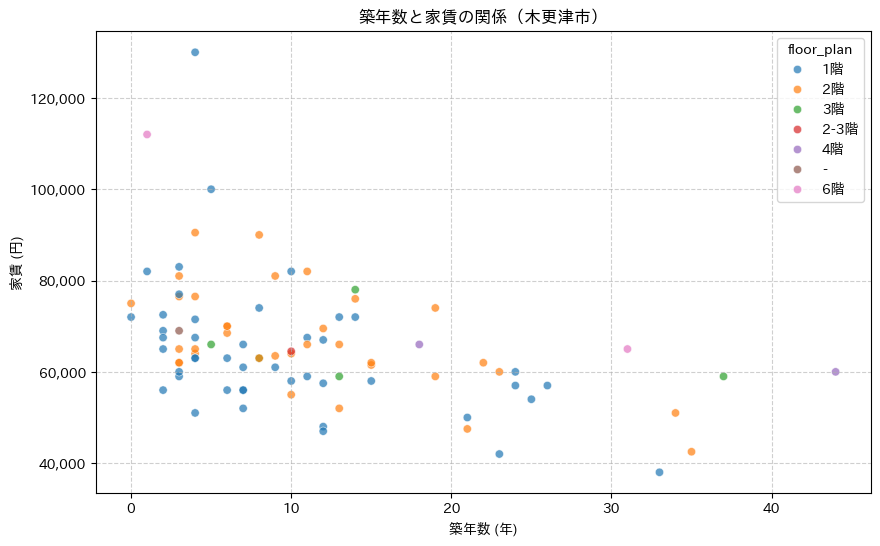

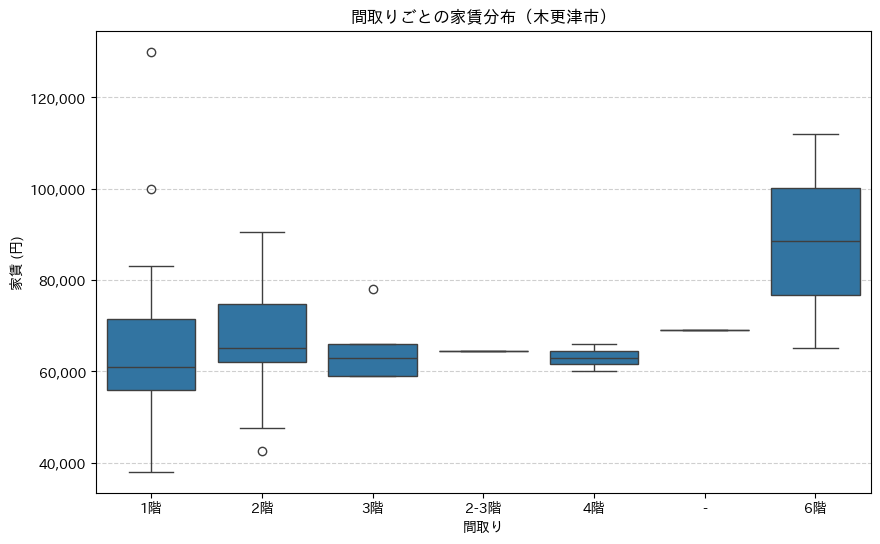

In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib # 日本語フォント用

# ==========================================
# 1. DB読み込み
# ==========================================
# 先ほど保存したファイル名 'saishukadai.db' に変更しました
conn = sqlite3.connect('saishukadai.db')
df = pd.read_sql("SELECT * FROM properties", conn)
conn.close()

# ==========================================
# 2. データ表示
# ==========================================
# データの有無を確認
if df.empty:
    print("データが読み込めませんでした。DBファイル名を確認してください。")
else:
    print(f"データ件数: {len(df)}件")
    print(df.head()) # 通常のPython環境なら print を使用

    # ==========================================
    # 3. グラフ1: 築年数 vs 家賃
    # ==========================================
    plt.figure(figsize=(10, 6))
    
    # style引数を追加して見やすくしました
    sns.scatterplot(data=df, x='age', y='price', hue='floor_plan', alpha=0.7)
    
    plt.title('築年数と家賃の関係（木更津市）')
    plt.xlabel('築年数 (年)')
    plt.ylabel('家賃 (円)')
    
    # 金額の軸を読みやすくフォーマット（例: 50000 -> 50,000）
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # ==========================================
    # 4. グラフ2: 間取りごとの家賃分布
    # ==========================================
    plt.figure(figsize=(10, 6))
    
    # 間取りの並び順を整えたい場合は order 引数を使いますが、まずは自動で表示
    sns.boxplot(data=df, x='floor_plan', y='price')
    
    plt.title('間取りごとの家賃分布（木更津市）')
    plt.xlabel('間取り')
    plt.ylabel('家賃 (円)')
    
    # 金額フォーマット
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

In [18]:
%%writefile app.py
import flet as ft
import sqlite3

def main(page: ft.Page):
    # アプリの基本設定
    page.title = "SUUMO賃貸データ検索アプリ"
    page.theme_mode = ft.ThemeMode.LIGHT
    page.window_width = 1000
    page.window_height = 800
    page.padding = 20

    # -----------------------------------------
    # 1. データベースからデータを取る関数
    # -----------------------------------------
    def get_data_from_db(keyword=""):
        conn = sqlite3.connect('suumo.db')
        cur = conn.cursor()
        
        if keyword:
            query = """
                SELECT name, station, price, age, floor_plan 
                FROM properties 
                WHERE station LIKE ? OR name LIKE ?
            """
            cur.execute(query, (f'%{keyword}%', f'%{keyword}%'))
        else:
            cur.execute("SELECT name, station, price, age, floor_plan FROM properties LIMIT 100")
            
        rows = cur.fetchall()
        conn.close()
        return rows

    # -----------------------------------------
    # 2. データを画面の「表」に変換する関数
    # -----------------------------------------
    def create_table_rows(data):
        rows = []
        for row in data:
            rows.append(
                ft.DataRow(
                    cells=[
                        ft.DataCell(ft.Text(row[0], size=12, weight="bold")), # 物件名
                        ft.DataCell(ft.Text(row[1], size=12)),                # 駅
                        ft.DataCell(ft.Text(f"{row[2]:,}円", color="blue")),  # 家賃
                        ft.DataCell(ft.Text(f"築{row[3]}年")),                # 築年数
                        ft.DataCell(ft.Text(row[4])),                         # 間取り
                    ]
                )
            )
        return rows

    # -----------------------------------------
    # 3. 画面パーツ（UI）の作成
    # -----------------------------------------
    title_text = ft.Text("賃貸データ分析ダッシュボード", size=24, weight="bold", color="teal")
    status_text = ft.Text("データを読み込み中...", color="grey")

    data_table = ft.DataTable(
        columns=[
            ft.DataColumn(ft.Text("物件名")),
            ft.DataColumn(ft.Text("最寄駅")),
            ft.DataColumn(ft.Text("家賃", numeric=True)),
            ft.DataColumn(ft.Text("築年数", numeric=True)),
            ft.DataColumn(ft.Text("間取り")),
        ],
        rows=[],
        border=ft.border.all(1, "grey"),
        vertical_lines=ft.border.BorderSide(1, "grey"),
        heading_row_color=ft.colors.BLUE_GREY_50,
        expand=True
    )

    # -----------------------------------------
    # 4. イベント処理
    # -----------------------------------------
    def search_click(e):
        keyword = search_field.value
        results = get_data_from_db(keyword)
        data_table.rows = create_table_rows(results)
        
        if len(results) == 0:
            status_text.value = "データが見つかりませんでした。"
            status_text.color = "red"
        else:
            status_text.value = f"検索結果: {len(results)} 件"
            status_text.color = "black"
            
        page.update()

    search_field = ft.TextField(
        label="駅名や物件名で検索（例: 新宿）", 
        width=400, 
        prefix_icon=ft.icons.SEARCH,
        on_submit=search_click
    )
    search_button = ft.ElevatedButton(text="検索", on_click=search_click)

    # 初期処理
    initial_data = get_data_from_db()
    data_table.rows = create_table_rows(initial_data)
    status_text.value = f"全データ表示中（最新100件）"

    # レイアウト
    page.add(
        ft.Column([
            title_text,
            ft.Divider(),
            ft.Row([search_field, search_button], alignment="center"),
            status_text,
            ft.Container(
                content=ft.Column([data_table], scroll=ft.ScrollMode.AUTO),
                height=500,
                border=ft.border.all(1, "grey50"),
                border_radius=10,
                padding=10
            )
        ])
    )

if __name__ == "__main__":
    ft.app(target=main)

Writing app.py
